In [3]:
import os
import nibabel as nib
import h5py
import numpy as np

# Usage Example:
# convert_brats_to_h5('path/to/BraTS20_Training_001', 'BraTS20_Training_001.h5')

def convert_brats_to_h5(patient_path, output_h5_path):
    """
    Combines BraTS modalities into a single HDF5 file. For a single patient folder.
    Structure: [Channels, Depth, Height, Width] -> (5, 155, 240, 240)
    """
    # Define suffixes for the files in each patient folder
    try:
        modalities = ['flair', 't1', 't1ce', 't2']
        patient_id = os.path.basename(patient_path)
        
        volumes = []
        
        # 1. Load the 4 MRI modalities
        for mod in modalities:
            file_path = os.path.join(patient_path, f"{patient_id}_{mod}.nii")
            img_obj = nib.load(file_path)

            # Re-orient to canonical (RAS) to ensure consistent starting point
            img_obj = nib.as_closest_canonical(img_obj)
            img = img_obj.get_fdata()

            volumes.append(img)
            
        # 2. Load the Segmentation Mask (Ground Truth)
        seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
        if os.path.exists(seg_path):
            seg_obj = nib.load(seg_path)

            # Reorient mask in same way as image
            seg_obj = nib.as_closest_canonical(seg_obj)
            seg = seg_obj.get_fdata()

            volumes.append(seg)
        
        # 3. Stack into a single array (Channels, H, W, D) 
        data_stack = np.stack(volumes, axis=0)

        # Rotate 90 degrees on the H/W plane to orient such that front of head is top of the image
        # and then transpose to (C, D, H, W)
        data_stack = np.rot90(data_stack, k=1, axes=(1, 2)) 
        data_stack = np.transpose(data_stack, (0, 3, 1, 2))     # Shape: (C, D, H, W)
        
        # 4. Save to HDF5
        with h5py.File(output_h5_path, 'w') as hf:
            hf.create_dataset('image', data=data_stack[:-1], compression="gzip")
            hf.create_dataset('mask', data=data_stack[-1], compression="gzip")
            hf.attrs['patient_id'] = patient_id

        return True
        # print(f"Successfully converted {patient_id} to HDF5. Stored at {output_h5_path}")

    except Exception as e:
        print(f"Error converting {patient_path}: {e}")
        return False


In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

def display_middle_slice_h5(h5_path, modality='T2'):
    """
    Opens an H5 file and displays the middle slice of the scan and the mask.
    Assumes shape is (Depth, Height, Width) or (Channels, Depth, Height, Width).
    
    Args:
        h5_path: Path to the H5 file
        modality: Which modality to display ('FLAIR', 'T1', 'T1CE', 'T2'). Default is 'T2'.
    """
    modality_names = {'FLAIR': 0, 'T1': 1, 'T1CE': 2, 'T2': 3}
    
    with h5py.File(h5_path, 'r') as hf:
        # Load the data
        image = hf['image'][:]  # Shape: (C, D, H, W)
        mask = hf['mask'][:]    # Shape: (D, H, W)
        
        # Determine the middle slice index along the depth axis (last axis)
        # BraTS is typically 155 slices deep
        mid_idx = image.shape[1] // 2
        print(f"Middle slice index: {mid_idx}")
        print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
        
        # Extract the slices
        if image.ndim == 4:  # If multi-channel (C, D, H, W)
            slice_img = image[modality_names[modality], mid_idx, :, :]
            mod_name = modality
        else:                # If single channel (D, H, W)
            slice_img = image[mid_idx, :, :]
            mod_name = 'MRI'
            
        slice_mask = mask[mid_idx, :, :]

        # Plotting
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.title(f"Middle Slice ({mid_idx}) - {mod_name}")
        im = plt.imshow(slice_img, cmap='gray')
        plt.colorbar(im, label='Intensity')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title(f"Middle Slice ({mid_idx}) - Mask")
        plt.imshow(slice_mask, cmap='jet') # 'jet' helps the tumor labels pop
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage:
# display_middle_slice_h5('path_to_your_file.h5', modality='FLAIR')
# display_middle_slice_h5('path_to_your_file.h5', modality='T1CE')

In [5]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

def display_middle_slice_nii(patient_path, modality='t2'):
    """
    Opens NIfTI files and displays the middle slice of the scan and the mask.
    
    Args:
        patient_path: Path to the patient folder containing NIfTI files
        modality: Which modality to display ('flair', 't1', 't1ce', 't2'). Default is 't2'.
    """
    patient_id = os.path.basename(patient_path)
    
    # Load the specific modality
    modality_file = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
    img = nib.load(modality_file).get_fdata()
    
    # Load the segmentation mask
    seg_file = os.path.join(patient_path, f"{patient_id}_seg.nii")
    mask = nib.load(seg_file).get_fdata()
    
    # Determine the middle slice index along the depth axis
    # BraTS is typically 155 slices deep (axis 2)
    mid_idx = img.shape[2] // 2
    
    # Extract the middle slice
    slice_img = img[:, :, mid_idx]
    slice_mask = mask[:, :, mid_idx]
    
    # Plotting
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title(f"Middle Slice ({mid_idx}) - {modality.upper()}")
    plt.imshow(slice_img.T, cmap='gray', origin='lower')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(f"Middle Slice ({mid_idx}) - Mask")
    plt.imshow(slice_mask.T, cmap='jet', origin='lower')  # 'jet' helps the tumor labels pop
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Displayed middle slice {mid_idx} from {patient_id} - {modality.upper()}")

# Example usage:
# display_middle_slice_nii('/path/to/BraTS20_Training_001', modality='flair')
# display_middle_slice_nii('/path/to/BraTS20_Training_001', modality='t1ce')

In [6]:
import nibabel as nib
import h5py
import numpy as np

def normalise_h5(input_h5_path, output_h5_path):
    """
    Load an H5 file, perform intensity normalization, and save to a new H5 file.
    Normalization is done per channel, only on non-zero voxels (brain tissue).
    
    Args:
        input_h5_path: Path to the input H5 file
        output_h5_path: Path to save the normalised H5 file
    """
    with h5py.File(input_h5_path, 'r') as hf_in:
        # Load the data
        image =  hf_in['image'][:]
        mask = hf_in['mask'][:]
        
        # Copy attributes if they exist
        attrs = dict(hf_in.attrs)
    
    # normalise the image data
    if image.ndim == 4:  # Multi-channel (C, D, H, W)
        normalised_image = np.zeros_like(image, dtype=np.float32)
        for channel in range(image.shape[0]):
            channel_data = image[channel]
            mask_brain = channel_data > 0
            if mask_brain.any():
                mean = channel_data[mask_brain].mean()
                std = channel_data[mask_brain].std()
                normalised_image[channel] = (channel_data - mean) / (std + 1e-8)
    else:  # Single channel (D, H, W)
        mask_brain = image > 0
        mean = image[mask_brain].mean()
        std = image[mask_brain].std()
        normalised_image = (image - mean) / (std + 1e-8)
    
    # Save to new H5 file
    with h5py.File(output_h5_path, 'w') as hf_out:
        hf_out.create_dataset('image', data=normalised_image.astype(np.float32), compression="gzip")
        hf_out.create_dataset('mask', data=mask.astype(np.uint8), compression="gzip")
        
        # Copy attributes
        for key, value in attrs.items():
            hf_out.attrs[key] = value
    
    # print(f"Successfully normalised and saved to {output_h5_path}")

# Example usage:
# normalise_h5('input_patient.h5', 'normalised_patient.h5')

In [7]:
import glob
import os
from pathlib import Path

cwd = Path.cwd()
print("Current working directory:", cwd) # /rds/general/user/km1422/home
root_path = cwd.parent/"projects"/"brainwearcwa"/"live"/"BrainWear_Kareem"

# Set paths
brats_root = root_path/"BraTS2020_TrainingData"/"MICCAI_BraTS2020_TrainingData"
search_pattern = str(brats_root/"BraTS20_Training_*")

patient_folders = glob.glob(search_pattern)

# Check all patient folders are present
assert len(patient_folders) == 369, f"Expected 369 patient folders in the BraTS20_TrainingData directory, found {len(patient_folders)}."
print(f"Found {len(patient_folders)} patient folders. All present")

# Check patient folder contains expected files
expected_files = ['flair', 't1', 't1ce', 't2', 'seg']
sample_patient = brats_root/"BraTS20_Training_001" #patient_folders[0]  # Just check any
print(f"Sample patient: {sample_patient}")
for mod in expected_files:
    file_path = os.path.join(sample_patient, f"{os.path.basename(sample_patient)}_{mod}.nii")
    assert os.path.exists(file_path), f"Expected file {file_path} not found in {sample_patient}."
print(f"Sample patient folder {os.path.basename(sample_patient)} contains all expected files.")

# Check output path exists
output_path = root_path/'Processed_BraTS2020_TrainingData'
os.makedirs(output_path, exist_ok=True)
assert os.path.exists(output_path), f"Output path {output_path} does not exist. Please create it before running the conversion."
print(f"Output path {output_path} is valid.")

Current working directory: /rds/general/user/km1422/home
Found 369 patient folders. All present
Sample patient: /rds/general/user/km1422/projects/brainwearcwa/live/BrainWear_Kareem/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001
Sample patient folder BraTS20_Training_001 contains all expected files.
Output path /rds/general/user/km1422/projects/brainwearcwa/live/BrainWear_Kareem/Processed_BraTS2020_TrainingData is valid.


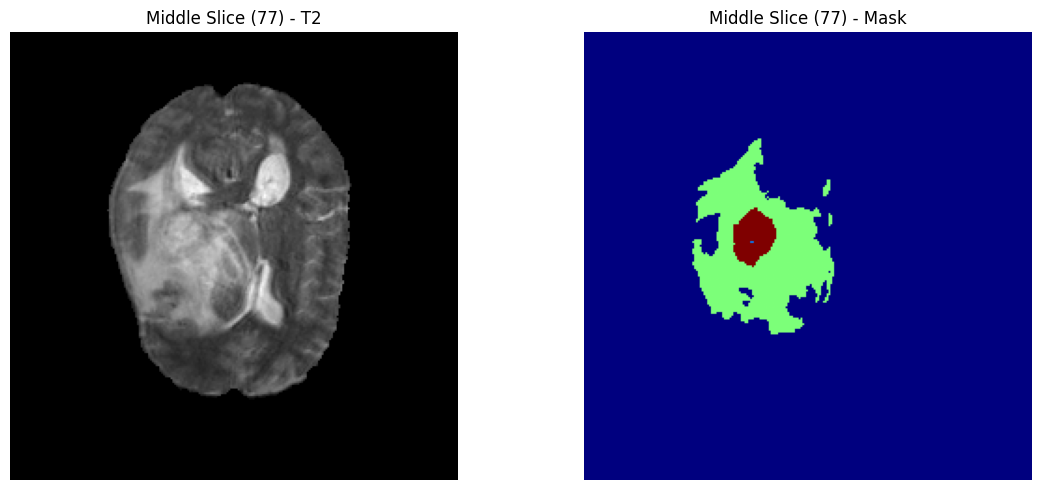

Displayed middle slice 77 from BraTS20_Training_001 - T2


In [8]:
# Display middle slice of sample patient to verify NIfTI files are readable
display_middle_slice_nii(sample_patient, modality='t2')

In [9]:
# Convert all patient folders in the BraTS20_Training directory to HDF5 files
failures = []
count = None       # Number of patient folders to convert for testing (set to None or remove for all)
if count is not None:
    print(f"Converting the first {count} patient folders for testing...")
    for patient_folder in patient_folders[:count]:
        patient_id = os.path.basename(patient_folder)
        output_h5 = os.path.join(output_path, f"{patient_id}.h5")
        print(f"Writing to output file: {output_h5}")
        converted_successfully = convert_brats_to_h5(patient_folder, output_h5)
        if not converted_successfully:
            failures.append(patient_id)
else:
    count = len(patient_folders)
    print("Converting all patient folders...")
    for i, patient_folder in enumerate(patient_folders):
        patient_id = os.path.basename(patient_folder)
        output_h5 = os.path.join(output_path, f"{patient_id}.h5")
        # print(f"Writing to output file: {output_h5}")
        converted_successfully = convert_brats_to_h5(patient_folder, output_h5)
        if not converted_successfully:
            failures.append(patient_id)
        if i % 10 == 0:
            print(f"{i}/{count} patients processed")

if failures:
    raise RuntimeError(f"Conversions failed for patients ids: {', '.join(failures)}")

# Check count patient folders were processed
processed_files = glob.glob(os.path.join(output_path, 'BraTS20_Training_*.h5'))
assert len(processed_files) == count, f"Expected {count} HDF5 files, but found {len(processed_files)}. Please check for any conversion errors."
print("All patient folders were successfully processed.")

Converting all patient folders...
0/369 patients processed
10/369 patients processed
20/369 patients processed
30/369 patients processed
40/369 patients processed
50/369 patients processed
60/369 patients processed
70/369 patients processed
80/369 patients processed
90/369 patients processed
100/369 patients processed
110/369 patients processed
120/369 patients processed
130/369 patients processed
140/369 patients processed
150/369 patients processed
160/369 patients processed
170/369 patients processed
180/369 patients processed
190/369 patients processed
200/369 patients processed
210/369 patients processed
220/369 patients processed
230/369 patients processed
240/369 patients processed
250/369 patients processed
260/369 patients processed
270/369 patients processed
280/369 patients processed
290/369 patients processed
300/369 patients processed
310/369 patients processed
320/369 patients processed
330/369 patients processed
340/369 patients processed
350/369 patients processed
360/3

In [10]:
# Batch normalize all HDF5 files in a folder
import glob
import os

# Define input and output folders
input_folder = output_path  # Folder containing HDF5 files to normalize
normalised_output_folder = root_path/'Normalised_BraTS2020_TrainingData'

# Create output folder if it doesn't exist
os.makedirs(normalised_output_folder, exist_ok=True)
print(f"Input folder: {input_folder}")
print(f"Output folder: {normalised_output_folder}")

# Find all HDF5 files in the input folder
h5_files = glob.glob(os.path.join(input_folder, '*.h5'))
total_h5_files = len(h5_files)

print(f"Found {total_h5_files} HDF5 files to normalize")
assert total_h5_files == count, f"Expected {count} HDF5 files, but found {total_h5_files}."


# Process each file
failures = []
for i, h5_file in enumerate(h5_files):
    try:
        # Get filename without path
        filename = os.path.basename(h5_file)
        
        # Define output path with same filename
        output_h5 = os.path.join(normalised_output_folder, filename)
        
        # Normalize and save
        normalise_h5(h5_file, output_h5)
        
        # Progress update
        if i % 10 == 0:
            print(f"{i}/{total_h5_files} files normalised")
            
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        failures.append(filename)

print(f"\nNormalization complete")
print(f"Successfully processed: {total_h5_files - len(failures)}/{total_h5_files}")

if failures:
    print(f"Failed files: {', '.join(failures)}")
else:
    print("All files normalized successfully!")

Input folder: /rds/general/user/km1422/projects/brainwearcwa/live/BrainWear_Kareem/Processed_BraTS2020_TrainingData
Output folder: /rds/general/user/km1422/projects/brainwearcwa/live/BrainWear_Kareem/Normalised_BraTS2020_TrainingData
Found 369 HDF5 files to normalize
0/369 files normalised
10/369 files normalised
20/369 files normalised
30/369 files normalised
40/369 files normalised
50/369 files normalised
60/369 files normalised
70/369 files normalised
80/369 files normalised
90/369 files normalised
100/369 files normalised
110/369 files normalised
120/369 files normalised
130/369 files normalised
140/369 files normalised
150/369 files normalised
160/369 files normalised
170/369 files normalised
180/369 files normalised
190/369 files normalised
200/369 files normalised
210/369 files normalised
220/369 files normalised
230/369 files normalised
240/369 files normalised
250/369 files normalised
260/369 files normalised
270/369 files normalised
280/369 files normalised
290/369 files norm

Displaying middle slice of /rds/general/user/km1422/projects/brainwearcwa/live/BrainWear_Kareem/Processed_BraTS2020_TrainingData/BraTS20_Training_001.h5 to verify conversion...
Middle slice index: 77
Image shape: (4, 155, 240, 240), Mask shape: (155, 240, 240)


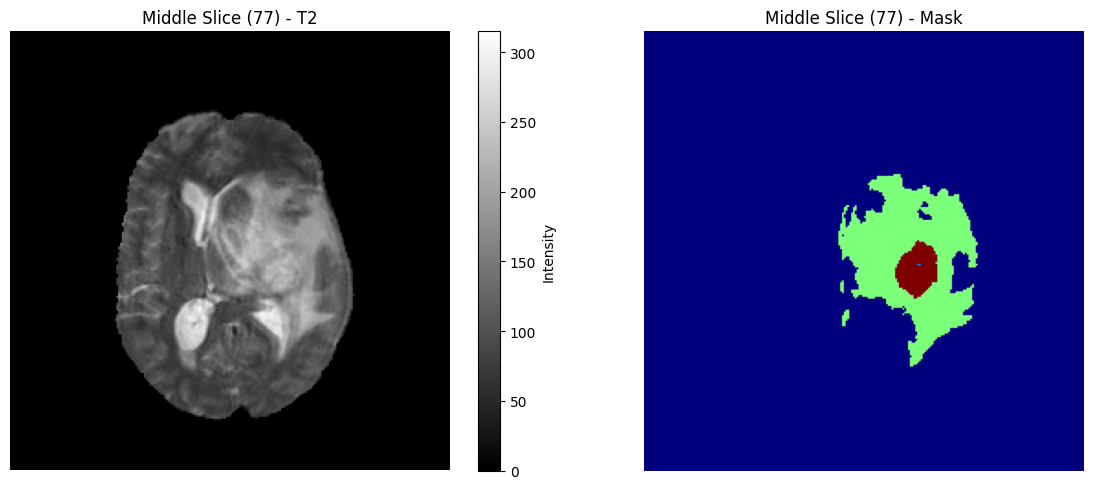

Middle slice index: 77
Image shape: (4, 155, 240, 240), Mask shape: (155, 240, 240)


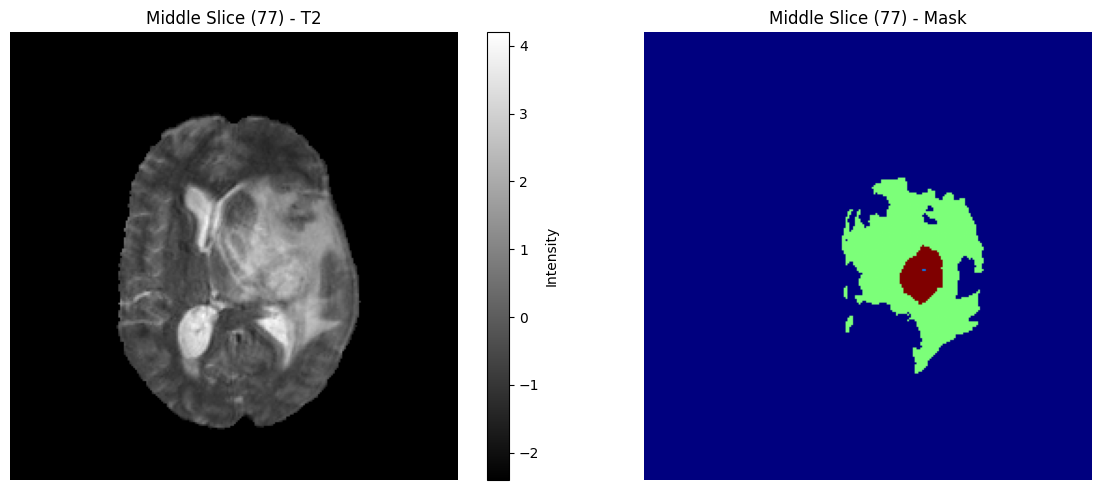

In [11]:
# Display the middle slice of one of the converted HDF5 files to verify
sample_patient_h5 = os.path.join(output_path, 'BraTS20_Training_001.h5')
print(f"Displaying middle slice of {sample_patient_h5} to verify conversion...")
display_middle_slice_h5(sample_patient_h5, modality='T2')

# Display normalised middle slice of the same HDF5
normalised_001_path = os.path.join(normalised_output_folder, 'BraTS20_Training_001.h5')
display_middle_slice_h5(normalised_001_path, modality='T2')